In [ ]:
pip install nilearn

In [ ]:
pip install pyinform

In [274]:
#Para usarlas es necesario instalar e importar las librerias networkx, numpy y nilearn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import connectome
import pyinform as pyin


def calculo_entropia(energias, particiones):
  """
  Esta función estima la entropía a partir del histograma de energías obtenido del metropolis
  ----------
  energias: array
  array con la energía para cada iteración
  particiones: número entero
  numero de particiones para construir el histograma
        
  regresa
  -------
  entropía : número real positivo
  """
  histograma, bin_edges = np.histogram(energias, bins = particiones)
  #ahora vamos a calcular la probabilidad y la entropia
  probabilidades = np.nonzero(histograma/len(energias))
  entropias = (-1.0)*probabilidades*np.log(probabilidades)
  entropia = np.sum(entropias)
  return entropia


def conectividad_mutual_entropy(time_series):

  time_series = time_series + 1.0
  conectividad = np.zeros((len(time_series),len(time_series)))
  for i in range(len(time_series)):
    for j in range(i+1,len(time_series)):
      value = pyin.mutual_info(time_series[i],time_series[j])
      conectividad[i][j] = value
      conectividad[j][i] = value
  np.fill_diagonal(conectividad,0.0)

  return conectividad


def conectividad_correlaciones(timeseries):
    """
    Esta función te da la conectividad funcional simulada a partir de las series de tiempo de la funcón metropolis
    ----------
    timeseries: array con el valor de spin para cada nodo en cada iteración
    
    regresa
    -------
    conectividad funcional simulada : array con correlaciones que toman valor de -1 a 1
    """
    transpuesto = list(map(list, zip(*timeseries)))
    # creemos la matriz de correlaciones con nilearn
    #creamos la función para correlación
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
    #creamos las matrices usando la función
    transpuesto = np.array(transpuesto) #hagamos un array de la lista donde estan las series de tiempo transpuestas
    simulation_matrix = correlation_measure.fit_transform([transpuesto])
    simulation_matrix = simulation_matrix[0]
    #hagamos la diagonal 0
    for i in range(1,len(simulation_matrix)):
      simulation_matrix[i][i] = 0
    return simulation_matrix



def metropolis_hastings(M, iteraciones, reinicios, T, acople, resistencia, high = 1.0, low = -1.0):

  M2 = np.dot(M, M)

  graf = nx.convert_matrix.from_numpy_array(M, parallel_edges=False, create_using = nx.DiGraph())
  graf.remove_edges_from(nx.selfloop_edges(graf))

  # Array en el que se depositan las series de tiempo de los nodos
  time_series = np.zeros((len(graf.nodes()), reinicios*iteraciones))
  # Array en el que se depositan las energias asociadas a cada estado de la red en cada iteracion
  E = np.zeros(reinicios*iteraciones)

  # Un vector donde se seleccionan aleatoriamente los nodos a los que se les cambiara su estado
  n = np.random.choice(graf.nodes(), size = reinicios*iteraciones)
  # Vector de numeros aleatorios para 
  number = np.random.rand(reinicios*iteraciones)

  for reinicio in range(reinicios):
  
    # Se crea un valor de spin para cada nodo aleatoriamente (condiciones iniciales)
    for i in graf.nodes():
        graf.nodes[i]['state'] = high if np.random.rand() < 0.5 else low

    energia = 0.0
    for nodes in graf.nodes():
      energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*(M[nodes,vecinos] + M2[nodes,vecinos]) for vecinos in graf.predecessors(nodes))
      energia += energia_nodo

    for i in range(iteraciones):

      estado_previo = graf.nodes[n[reinicio*iteraciones + i]]['state']

      graf.nodes[n[reinicio*iteraciones + i]]['state'] = high if estado_previo == low else low 

      energia_cambio = 0.0
      for nodes in graf.nodes():
        energia_nodo = graf.nodes[nodes]['state']*(resistencia[nodes]/2.0) -(acople/2.0)*graf.nodes[nodes]['state']*np.sum(graf.nodes[vecinos]['state']*M[nodes,vecinos] for vecinos in graf.predecessors(nodes))
        energia_cambio += energia_nodo

      de = energia_cambio - energia
      #p = (np.exp(-de/T))/(1.0 + np.exp(-de/T))
      p = np.exp(-de/T)

      if number[reinicio*iteraciones + i] < p:
        energia = energia_cambio
      else:
        graf.nodes[n[reinicio*iteraciones + i]]['state'] = estado_previo


      E[reinicio*iteraciones + i] = energia

      for k in graf.nodes():
        time_series[k, reinicio*iteraciones + i] = graf.nodes[k]["state"]

  return E, time_series


In [5]:
def plotmatrix(M, n = False):
  """
  Grafica la matriz de adyacencia de un grafo

  Parámetros
  ----------
  M : Matriz de adyacencia
  n : Si es True grafica la matriz como log1p(M) / Si es False grafica M

  """
  if n == True:
    K = np.log1p(M)
  else:
    K = M
  im = plt.imshow(K)
  plt.colorbar(im)
  plt.show()

In [4]:
#%% Conectar con google drive, donde se encuentran los datos HCP1200 requeridos
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [253]:
M = np.load('/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Datos Proyecto Conectoma Humano (HCP)/100610/Parcelas/AAL/EST_100610ME.npy')

In [165]:
Diagonales = M.diagonal()
Zeros = np.zeros(M.shape[0])

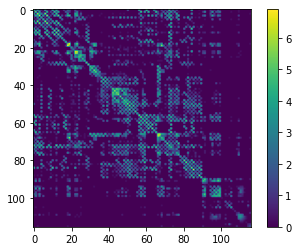

In [37]:
plotmatrix(M*1000.0, n = True)

In [275]:
E, time_series = metropolis_hastings(M, iteraciones = 500, reinicios = 10, T = 0.135, acople = 1.0, resistencia = np.zeros(M.shape[0]), high = 1.0, low = -1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


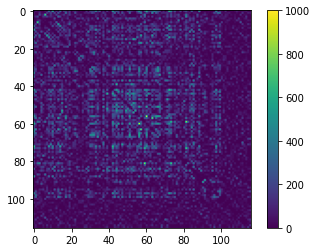

In [276]:
SIM = conectividad_mutual_entropy(time_series)
SIM = SIM/np.max(SIM)
plotmatrix(SIM*1000.0, n = False)

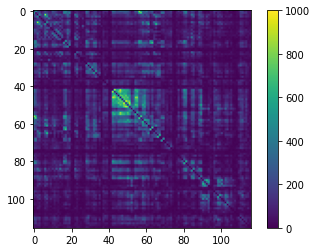

In [277]:
EXP = np.load('/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Datos Proyecto Conectoma Humano (HCP)/100610/Parcelas/AAL/REST1_100610ME.npy')
EXP = EXP/np.max(EXP)
plotmatrix(EXP*1000.0, n = False)

In [278]:
aver = np.linalg.norm(SIM - EXP)
aver

15.059552745911054

In [266]:
steps = 10
min = 0.0
max = 1.5

temperatura, distancia = find_temperature(min, max, steps, M, EXP, num_pruebas = 3)

print(temperatura, ' ' , distancia)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


14.0323514630672 1
14.0323514630672 1
14.0323514630672 1
14.0323514630672 1
14.0323514630672 1
14.0323514630672 1
14.0323514630672 1
13.949958532825224 2
13.920529223274421 3
13.920529223274421 3
13.920529223274421 3
13.920529223274421 3
13.920529223274421 3
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
13.759753189499536 2
0.328125   13.759753189499536


In [265]:
def find_temperature(min, max, steps, M, EXP, num_pruebas = 3):

  puntos = num_pruebas + 2
  valores = np.linspace(min, max, puntos)

  max_fit = 100.0
  max_index = 0
  valor = 0.0

  for step in range(steps):

    for index in range(1, len(valores)-1):

      E, time_series = metropolis_hastings(M, iteraciones = 500, reinicios = 10, T = valores[index], acople = 1.0, resistencia = np.zeros(M.shape[0]), high = 1.0, low = -1.0)
      SIM = conectividad_mutual_entropy(time_series)
      SIM = SIM/np.max(SIM)
      fit = np.linalg.norm(SIM - EXP)

      if max_fit > fit:
        max_index = index
        max_fit = fit
        valor = valores[index]

      print(max_fit, max_index)

    valores = np.linspace(valores[max_index - 1], valores[max_index + 1], puntos)

  return valor, max_fit

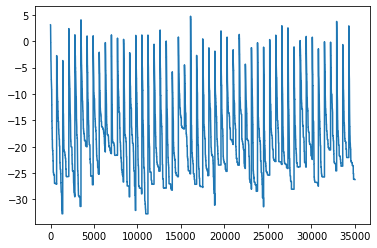

In [161]:
x=np.linspace(1,len(E),len(E))
y = E

# Plot
plt.plot(x,y)